In [1]:
import pandas as pd
import numpy as np

In [3]:
data=pd.read_csv("./term-deposit-marketing-2020.csv")


In [4]:
data['y'].value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

Out of 40K customers contacted in the marketing campaign, 37104 customers (93%) did not subscribe and 2896 customers (7%) subscribed to a term-deposit. There is a class imbalance. 

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

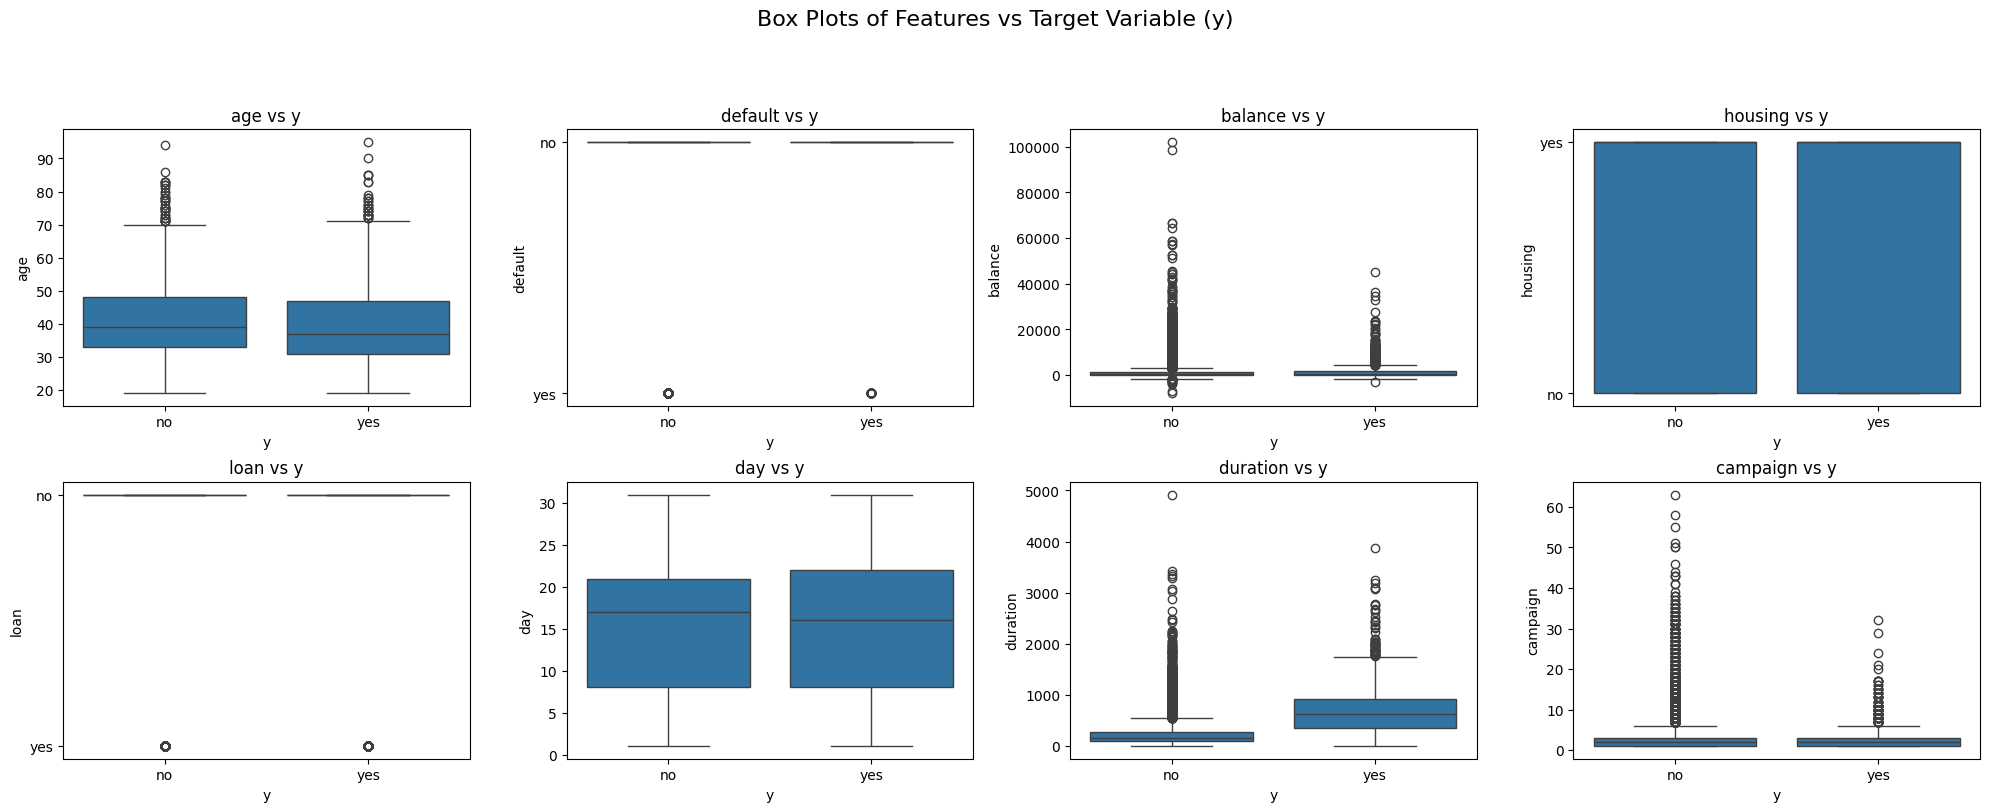

In [12]:
X = data.drop(['y'],axis=1)
y= data['y']
features=X.columns

# List of categorical features to exclude from box plots
categorical_features = ['job', 'marital', 'education', 'contact', 'month']

# Filter out categorical features to get only numeric and binary features
numeric_features = [feature for feature in features if feature not in categorical_features]

# Create a grid of subplots (4 rows x 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
fig.suptitle('Box Plots of Features vs Target Variable (y)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='y', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'{feature} vs y')

# Remove any empty subplots (there will be 3 empty plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top for the suptitle
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'yaxis'

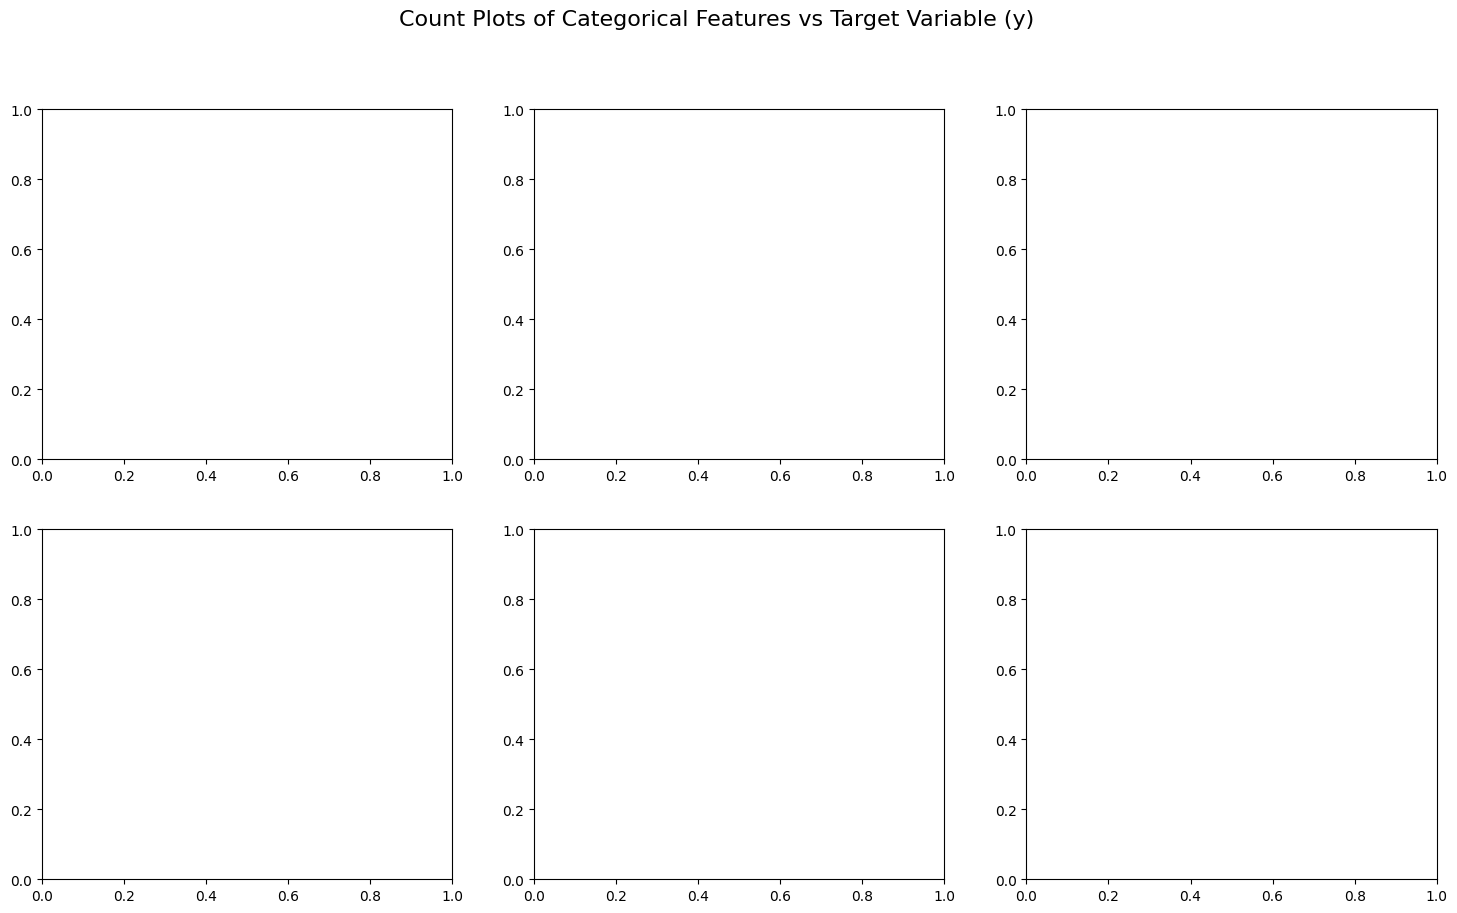

In [14]:
# Create a grid of subplots (2 rows x 3 columns, more than enough for 5 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Count Plots of Categorical Features vs Target Variable (y)', fontsize=16)

# Loop through each categorical feature and create a count plot
for i, feature in enumerate(categorical_features):
    if i < len(axes):  # Ensure we don't exceed the number of available axes
        sns.countplot(x=feature, hue='y', data=data, ax=axes[i])
        axes[i].set_title(f'{feature} vs y')
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels for better visibility

# Remove any unused subplots (since we only have 5 plots)
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])  # Correctly access the axes to delete

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust top for the suptitle
plt.show()